# Construction and validation of bioNLP named entity recognition model using deep learning
Problems: the embeddings I trained is worse than the one from google

deep_nlp_serial

Attribution: 
    Some of the code are borrowed from the example code from spacy

In [1]:
#!conda install nb_conda



In [2]:
import tensorflow
from tqdm import tqdm

In [3]:
#!ls  /cellar/users/btsui/anaconda3/lib/python3.6/site-packages/tensorflow/

In [4]:
##!rm -r /cellar/users/btsui/anaconda3/lib/python3.6/site-packages

In [5]:
#tensorflow

In [6]:
#!ls /cellar/users/btsui/anaconda3/lib/python3.6/site-packages/

In [7]:
#!pip install pandas

In [8]:
import keras

Using TensorFlow backend.


In [9]:
import random
import pathlib
import cytoolz
import numpy
from keras.models import Sequential, model_from_json
from keras.layers import LSTM, Dense, Embedding, Bidirectional
from keras.layers import TimeDistributed
from keras.optimizers import Adam
import thinc.extra.datasets
from spacy.compat import pickle
import spacy
import pandas as pd
from sklearn import preprocessing
import keras
from sklearn import model_selection
#import seaborn as sns
from sklearn import metrics
#import matplotlib.pyplot as plt

/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


### load in SRA data

In [10]:
%%time 
inS_dir='/cellar/users/btsui/Data/nrnb01_nobackup/METAMAP/allSRS.pickle'

sra_dump_pickle_dir='/cellar/users/btsui/Data/SRA/DUMP/sra_dump.pickle'

srsS=pd.read_pickle(inS_dir)
srsS=pd.Series(data=srsS.values,index=pd.MultiIndex.from_arrays([srsS.index.get_level_values(0),
                                                            srsS.index.get_level_values(1).str.lower()]) )
technical_meta_data_df=pd.read_pickle(sra_dump_pickle_dir)


CPU times: user 42.6 s, sys: 6.86 s, total: 49.4 s
Wall time: 49.4 s


In [11]:
#srsS.memory_usage()/10**9

### load in spacy models

In [12]:
%%time
#nlp=spacy.load('en_vectors_web_lg')
nlp=spacy.load('./wikipedia-pubmed-and-PMC-w2v')

/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


CPU times: user 48.2 s, sys: 5.52 s, total: 53.8 s
Wall time: 53.7 s


### Functions for model compilation and feature extraction

Useful information for understanding the neural network: 

TimeDistributed: https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

lr stands for: learning rate

In [13]:
def compile_lstm(embeddings, shape, settings):
    model = Sequential()
    model.add(
        Embedding(
            embeddings.shape[0],
            embeddings.shape[1],
            input_length=shape['max_length'],
            trainable=False,
            weights=[embeddings],
            mask_zero=True
        )
    )
    #the same dense layer is first applied extract the most useful info from embedding layers
    model.add(TimeDistributed(Dense(shape['nr_hidden'], use_bias=False)))
    model.add(Bidirectional(LSTM(shape['nr_hidden'],
                                 recurrent_dropout=settings['dropout'],
                                 dropout=settings['dropout'])))
    model.add(Dense(shape['nr_class'], activation='sigmoid'))
    model.compile(optimizer=Adam(lr=settings['lr']), loss='categorical_crossentropy',
		  metrics=['accuracy'])
    return model

def get_features(docs, max_length):
    docs = list(docs)
    Xs = numpy.zeros((len(docs), max_length), dtype='int32')
    for i, doc in tqdm(enumerate(docs),total=len(docs)):
        j = 0
        for token in doc:
            ##rever to word vector
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs

### subset sra data

In [14]:
#max_length=10
max_sample_per_study_n=100


In [15]:
srsWithText=srsS.index.get_level_values(0).unique()

In [16]:
### take only intersection and than randomize the dataframe
tmpDf=technical_meta_data_df.drop_duplicates('Sample')
tmpInterDf=tmpDf[tmpDf.Sample.isin(srsWithText)]
shuffledDf=tmpInterDf.sample(n=tmpInterDf.shape[0],random_state=0
                                            )
technical_meta_data_df_sub=shuffledDf.groupby('Study').head(n=max_sample_per_study_n)

In [17]:
print ('# of unique studies:',technical_meta_data_df_sub.Study.nunique())

# of unique studies: 106110


### subset data based on entity types 

In [18]:
train_test_ratio=0.8

In [19]:
#srsS.str.contains(filterTextRegex)

In [74]:
subsampledSrs=technical_meta_data_df.groupby('Study').head(n=max_sample_per_study_n)['Sample']
#,'dev_stage','phenotype'
#'treatment',
#,'strain'
"""
breed           0.587882
cell_line       0.621203
"""
#'breed',
myAttribs=['organism','geo_loc_name','sex','tissue','age','genotype',
           'body_product',
           'disease']
print ('classify:'.format(", ".join(myAttribs)))
#myAttribs=['SCIENTIFIC_NAME','biomaterial_provider','race','population_description','source_name','sex','age','strain','genotype','disease','treatment']
m=srsS.index.get_level_values(0).isin(subsampledSrs.values)
m1=srsS.index.get_level_values(1).isin(myAttribs)
srsS_subS=srsS[m&m1]

classify:


In [75]:
filterTextL=['not collected','not applicable','missing','n[/]?a']

filterTextRegex="|".join(map(lambda myStr:'(?:{})'.format(myStr),filterTextL))

In [76]:
srs_filterM=srsS_subS.str.contains(filterTextRegex,case=False)
srsS_subS=srsS_subS[~srs_filterM]

In [77]:
myDf=srsS_subS.reset_index()
myDf.columns=['srs','attrib','sentence']

In [78]:
myDf['sentence']=myDf['sentence'].str.replace('_','')

### split data into training and  testing randomly by study levels

It is split by study level to avoid overgeneralization

In [79]:
study_S=technical_meta_data_df_sub['Study'].drop_duplicates()
print (len(study_S))
myNStudies=len(study_S)
train_n=int((myNStudies*train_test_ratio))
train_studies=study_S.sample(n=train_n,random_state=0).values

106110


In [80]:
technical_meta_data_df_sub['Train']=\
    technical_meta_data_df_sub['Study'].isin(train_studies)

/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [81]:
train_mask=technical_meta_data_df_sub['Train']
train_samples=technical_meta_data_df_sub['Sample'][train_mask].values
test_samples=technical_meta_data_df_sub['Sample'][~train_mask].values


In [82]:
### set training and testing within the dataframe
#inTrainTestDf=myDf.sample(n=myDf.shape[0]).groupby('attrib').head(n=20000)
cap_size=20000#20000#1000#50000

all_train_df=myDf[myDf.srs.isin(train_samples)]
g=all_train_df.groupby('attrib')
print (g.size().min())
#train_df=g.head(g.size().min())
train_df=all_train_df.sample(n=all_train_df.shape[0]).groupby('attrib').head(n=cap_size)
all_test_df=myDf[myDf.srs.isin(test_samples)]
test_df=all_test_df.sample(n=all_test_df.shape[0]).groupby('attrib').head(cap_size)
#cap_size=g.size().min()


3448


In [83]:
attribVC_train=train_df.attrib.value_counts()#.to_frame()

In [84]:
train_df.head()

,srs,attrib,sentence
397990,SRS1246625,age,22
726830,SRS1078938,age,embryonic day E10.5
58303,SRS952557,sex,female
715709,SRS702492,sex,female
323667,SRS981039,tissue,nuclear transfer embryo


### set up LSTM model

In [85]:
nr_hidden=64
max_length=65#, # Shape
dropout=0.5
learn_rate=0.001#, # General NN config
nb_epoch=1#
batch_size=100

use the sklearn encoder going back and forth between classes in string format and integer format

In [86]:
le = preprocessing.LabelEncoder()
le.fit(myAttribs)
nr_classes=len(le.classes_)

In [87]:
lstm_shape={'nr_hidden': 64, 'max_length': max_length, 'nr_class': nr_classes}
lstm_settings={'dropout': 0.5, 'lr': 0.001}

In [88]:
embeddings = nlp.vocab.vectors.data
#embedgigs is vocab.vectors.data
model = compile_lstm(embeddings, lstm_shape, lstm_settings)

### transform list of freetexts into a matrix of word embeddings

In [89]:
train_texts=train_df.sentence.tolist()
dev_texts=test_df.sentence.tolist()

train_labels=keras.utils.to_categorical(
    le.transform(train_df.attrib.values))
dev_labels=keras.utils.to_categorical(le.transform(test_df.attrib.values))

train_docs = list(tqdm(nlp.pipe(train_texts,n_threads=32),total=len(train_texts)))
dev_docs = list(tqdm(nlp.pipe(dev_texts,n_threads=32),total=len(dev_texts)))

train_X = get_features(train_docs, lstm_shape['max_length'])
dev_X = get_features(dev_docs, lstm_shape['max_length'])

100%|██████████| 101136/101136 [00:00<00:00, 215242.47it/s]


In [90]:
#train_texts

#### Model training


#26 mins per epoch, on a machine with 48 threads, might want to use GPU machine bordeaux for this 


In [91]:
model_path='./model/lstm.h5'

In [92]:
log_dir="logs/"#.format(time())

In [93]:
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint


In [94]:
#filepath="./model/weights.best.hdf5"
checkpoint = ModelCheckpoint(model_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


In [95]:
!rm log.csv

In [96]:
tf_callBack=keras.callbacks.TensorBoard(log_dir=log_dir)
csv_logger = CSVLogger('log.csv', append=True, separator=';')
call_backs = [csv_logger,tf_callBack,checkpoint]

In [97]:
numpy.save('./model/classes.npy', le.classes_)


In [ ]:
lstm=model.fit(train_X, train_labels, validation_data=(dev_X, dev_labels),
          nb_epoch=nb_epoch,verbose=1, batch_size=batch_size,callbacks=call_backs)

/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 136283 samples, validate on 101136 samples
Epoch 1/1
115500/136283 [========================>.....] - ETA: 2:04 - loss: 0.3041 - acc: 0.9303

In [ ]:
from keras.models import load_model


In [ ]:
#model=load_model('./model/lstm.h5')

In [ ]:
#loss_history = lstm.history['loss']
#numpy_loss_history = numpy.array(loss_history)
#numpy.savetxt("loss_history.txt", numpy_loss_history, delimiter=",")

In [ ]:
val_docs = list(tqdm(nlp.pipe(dev_texts,),total=len(dev_texts)))
val_X=get_features(val_docs,lstm_shape['max_length'])
%time predictM=lstm.model.predict_proba(val_X)

In [ ]:
probaDf_multI=pd.DataFrame(data=predictM,columns=le.classes_)

In [ ]:
probaDf_multI.index=pd.MultiIndex.from_arrays([test_df.attrib.values,dev_texts],names=['entity','text'])

In [ ]:
probaDf=probaDf_multI.reset_index()

In [ ]:
predicted_types=probaDf.loc[:,probaDf.columns.isin(myAttribs)].idxmax(axis=1)


In [ ]:
print (((probaDf.entity==predicted_types).mean()))

### show contingency tables

In [ ]:
#filterTextL=['not collected','not applicable','missing','n[/]?a']

#filterTextRegex="|".join(map(lambda myStr:'(?:{})'.format(myStr),filterTextL))

In [ ]:
#m_cleanText=~probaDf_multI.index.get_level_values('text').str.contains(filterTextRegex,case=False)

In [ ]:
#probaDf_multI

In [ ]:
inEvalDf=probaDf_multI#[m_cleanText]

In [ ]:
minProbThreshold=0.2
confidence_mask=inEvalDf.max(axis=1)>=minProbThreshold
tmpDf3=inEvalDf[confidence_mask].idxmax(axis=1).reset_index(name='predicted')

In [ ]:
tmpDf3.groupby('predicted').size()

In [ ]:
continDf=tmpDf3.groupby(['predicted','entity']).size().unstack().fillna(0)

In [ ]:
continDf.columns=continDf.columns.copy()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

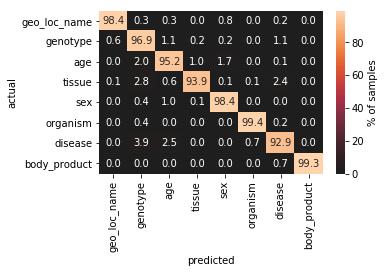

In [154]:
fig,ax=plt.subplots(figsize=(5,3))
#,cmap="Greens"
continDf=continDf.loc[attribVC_train.index,attribVC_train.index]
continDf.index=continDf.index.copy()
continDf.columns=continDf.columns.copy()
continDf.index.name='predicted'
continDf.columns.name='actual'
sns.heatmap(ax=ax,data=(continDf/continDf.sum(axis=0)).T*100,annot=True,cbar_kws={'label':'% of samples'},center=0.3,
           fmt='.1f')
fig.savefig('./Results/Figures/entity_contingency.pdf')
fig.savefig('./Results/Figures/entity_contingency.png',dpi=300)

In [139]:
#sns.heatmap((continDf.T/continDf.sum(axis=1)).T,annot=True)

In [ ]:
#continDf#.sum(axis=0)


#### Performance of model in validation cohort

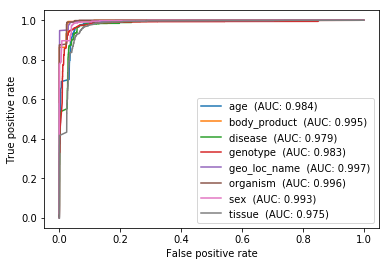

In [127]:
fig,ax=plt.subplots()
for myClass in le.classes_: 
    fpr,tpr,_=metrics.roc_curve((probaDf.entity==myClass),probaDf[myClass])    
    ax.plot(fpr,tpr,label="{myClass}  (AUC: {AUC})".format(myClass=myClass,AUC=str(metrics.auc(fpr,tpr))[:5]))
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.legend()

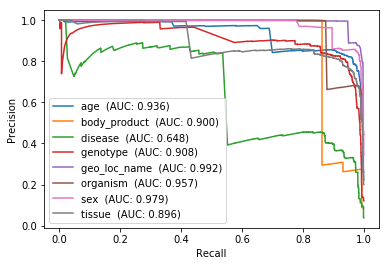

In [137]:
fig,ax=plt.subplots()
for myClass in le.classes_: 
    precision,recall,_=metrics.precision_recall_curve((probaDf.entity==myClass),probaDf[myClass])    
    ax.plot(recall, precision,label="{myClass}  (AUC: {AUC})".format(myClass=myClass,AUC=str(metrics.auc(recall,precision))[:5]))
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()

In [157]:
#probaDf

In [158]:
#for myClass in le.classes_: 
#    print (myClass,metrics.f1_score((probaDf.entity==myClass),probaDf[myClass]))


### entities

In [161]:
entity_a=inEvalDf.index.get_level_values('entity')

In [162]:
inTmpDf=inEvalDf.idxmax(axis=1).reset_index(name='predicted')

In [163]:
inTmpDf['correct']=inTmpDf.entity==inTmpDf.predicted

In [164]:
inTmpDf.groupby('entity')['correct'].mean().sort_values()

entity
disease         0.892203
tissue          0.927500
age             0.941500
genotype        0.950873
sex             0.973500
geo_loc_name    0.982400
organism        0.986816
body_product    0.993572
Name: correct, dtype: float64

In [167]:
#inEvalDf[entity_a=='breed'].sort_values('breed',ascending=False).index.get_level_values('text').value_counts()

In [166]:
inEvalDf.head()

age  body_product   disease  \
entity       text                                                      
geo_loc_name Saudi Arabia: Red Sea  0.000006      0.000001  0.000007   
tissue       root                   0.476081      0.426237  0.436133   
             tubers                 0.004445      0.000052  0.013901   
age          modern                 0.153561      0.051979  0.018857   
geo_loc_name Mali: populationM2     0.000030      0.000004  0.000182   

                                    genotype  geo_loc_name  organism  \
entity       text                                                      
geo_loc_name Saudi Arabia: Red Sea  0.000050      0.932352  0.000015   
tissue       root                   0.611523      0.406561  0.416583   
             tubers                 0.000858      0.000038  0.000123   
age          modern                 0.091773      0.151505  0.077876   
geo_loc_name Mali: populationM2     0.000925      0.415475  0.000020   

                                         sex    tissue  
entity       text                                       
geo_loc_name Saudi Arabia: Red Sea  0.000013  0.000014  
tissue       root                   0.430139  0.477389  
             tubers                 0.000043  0.523623  
age          modern                 0.053660  0.271690  
geo_loc_name Mali: populationM2     0.000071  0.000026

### calculated F1 score

In [174]:
"""
``'binary'``:
        Only report results for the class specified by ``pos_label``.
        This is applicable only if targets (``y_{true,pred}``) are binary.
    ``'micro'``:
        Calculate metrics globally by counting the total true positives,
        false negatives and false positives.
    ``'macro'``:
        Calculate metrics for each label, and find their unweighted
        mean.  This does not take label imbalance into account.
    ``'weighted'``:
        Calculate metrics for each label, and find their average, weighted
        by support (the number of true instances for each label). This
        alters 'macro' to account for label imbalance; it can result in an
        F-score that is not between precision and recall.
    ``'samples'``:
        Calculate metrics for each instance, and find their average (only
        meaningful for multilabel classification where this differs from
        :func:`accuracy_score`).
"""
print( metrics.f1_score(y_true=inTmpDf['entity'],y_pred=inTmpDf['predicted'],average='weighted'))

0.9560190916500529


# scratch

In [ ]:
asdadasd

### for a sentence split

In [ ]:
import nltk
from nltk.util import ngrams

sent="T cell is treated with LPS grow faster"
s=sent.split(' ')
n_gram=2
grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
print (grams)
val_docs = list(nlp.pipe(grams))
val_X=get_features(val_docs,lstm_shape['max_length'])
tmpDf=pd.DataFrame(data=lstm.model.predict_proba(val_X),columns=le.classes_,index=grams)
ax=sns.heatmap(tmpDf,cbar_kws={'label': 'Emitted probability'},annot=True)
ax.set_ylabel('')
ax.set_title('{} grams'.format(n_gram))

In [ ]:
val_X=get_features(val_docs,lstm_shape['max_length'])

In [ ]:
!echo $PWD/Data/DEEP_NLP/NLP_spacy/keras_on_sra_data_v2.ipynb

In [ ]:


tmpS3=srsS[srsS.index.get_level_values(1)=='cur_land_use']

In [ ]:
len(tmpS3.value_counts())

In [ ]:
#no data: biomass,chem_mutagen
srsS.head()

In [ ]:
def most_similar(word):
    by_similarity = sorted(word.vocab, key=lambda w: word.similarity(w), reverse=True)
    return [w.orth_ for w in by_similarity[:10]]

In [ ]:
#most_similar(nlp.vocab['missing'])